In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import random
import os
from tqdm import tqdm


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),  # Standard CIFAR-10 normalization
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])


train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


In [ ]:
class SubsetWithTargets(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        return image, label, self.indices[idx]

    def __len__(self):
        return len(self.indices)

def collate_fn_with_index(batch):
    images, labels, indices = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    indices = torch.tensor(indices)
    return images, labels, indices

In [ ]:
def get_model():
    model = torchvision.models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model


In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for x, y, _ in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


In [ ]:
def get_probs(model, dataloader, device):
    model.eval()
    probs, indices = [], []
    with torch.no_grad():
        for x, _, idx in dataloader:
            x = x.to(device)
            out = F.softmax(model(x), dim=1)
            probs.append(out.cpu())
            indices.extend(idx)
    return torch.cat(probs), indices

def query_samples(strategy, model, unlabeled_loader, already_selected, budget, device):
    probs, indices = get_probs(model, unlabeled_loader, device)

    if strategy == 'random':
        candidates = list(set(indices) - set(already_selected))
        return random.sample(candidates, budget)

    elif strategy == 'least_confident':
        scores = 1 - probs.max(dim=1)[0]
    elif strategy == 'margin':
        top2 = torch.topk(probs, 2, dim=1).values
        scores = top2[:,0] - top2[:,1]
    elif strategy == 'entropy':
        scores = -torch.sum(probs * probs.log(), dim=1)
    elif strategy == 'density':
        embeddings = probs.numpy()
        dist = pairwise_distances(embeddings, embeddings)
        scores = -dist.mean(axis=1)
    elif strategy == 'diversity':
        embeddings = probs.numpy()
        kmeans = KMeans(n_clusters=budget)
        kmeans.fit(embeddings)
        _, closest = pairwise_distances(embeddings, kmeans.cluster_centers_).min(axis=1), \
                     pairwise_distances(embeddings, kmeans.cluster_centers_).argmin(axis=1)
        selected = np.unique(closest)
        return [indices[i] for i in selected[:budget]]
    else:
        raise ValueError("Unknown strategy:", strategy)

    topk = torch.topk(scores, budget).indices
    return [indices[i] for i in topk]


In [ ]:
def plot_metrics(train_accs, val_accs, train_losses, val_losses, round_num, strategy):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title(f'Accuracy after round {round_num} - {strategy}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Loss after round {round_num} - {strategy}')
    plt.legend()
    plt.show()


In [ ]:
def active_learning_loop(strategy='random', init_size=1000, query_size=1000, rounds=10, batch_size=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    all_indices = list(range(len(train_data)))
    np.random.seed(42)
    initial_labeled = np.random.choice(all_indices, init_size, replace=False).tolist()
    labeled_indices = initial_labeled.copy()
    unlabeled_indices = list(set(all_indices) - set(labeled_indices))

    labeled_set = SubsetWithTargets(train_data, labeled_indices)
    unlabeled_set = SubsetWithTargets(train_data, unlabeled_indices)

    val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    acc_history, sample_counts = [], []

    for round in range(rounds):
        print(f"\n🌀 Round {round+1} - Strategy: {strategy}")
        model = get_model().to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_with_index)

        train_accs, val_accs, train_losses, val_losses = [], [], [], []
        for epoch in range(5):
            train_loss, train_acc = train(model, labeled_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

        acc_history.append(val_acc)
        sample_counts.append(len(labeled_set))
        plot_metrics(train_accs, val_accs, train_losses, val_losses, round+1, strategy)

        # Select new samples
        if round < rounds - 1:
            unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_with_index)
            selected = query_samples(strategy, model, unlabeled_loader, labeled_indices, query_size, device)
            labeled_indices.extend(selected)
            unlabeled_indices = list(set(unlabeled_indices) - set(selected))
            labeled_set = SubsetWithTargets(train_data, labeled_indices)
            unlabeled_set = SubsetWithTargets(train_data, unlabeled_indices)

    # Final plot: Accuracy vs. Number of labeled samples
    plt.figure(figsize=(8, 5))
    plt.plot(sample_counts, acc_history, marker='o')
    plt.title(f'Final Accuracy vs. Number of Labeled Samples - {strategy}')
    plt.xlabel('Number of Labeled Samples')
    plt.ylabel('Validation Accuracy')
    plt.grid()
    plt.show()

    return acc_history, sample_counts, strategy



🌀 Round 1 - Strategy: random
Epoch 1: Train Acc=0.109, Val Acc=0.156
Epoch 2: Train Acc=0.146, Val Acc=0.197
Epoch 3: Train Acc=0.174, Val Acc=0.233
Epoch 4: Train Acc=0.196, Val Acc=0.246
Epoch 5: Train Acc=0.248, Val Acc=0.257


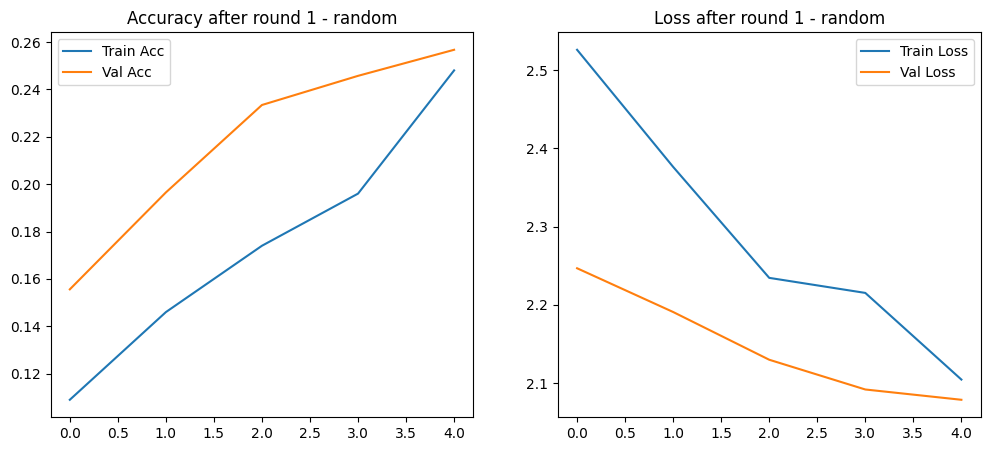


🌀 Round 2 - Strategy: random
Epoch 1: Train Acc=0.109, Val Acc=0.166
Epoch 2: Train Acc=0.181, Val Acc=0.221
Epoch 3: Train Acc=0.227, Val Acc=0.239
Epoch 4: Train Acc=0.260, Val Acc=0.263
Epoch 5: Train Acc=0.281, Val Acc=0.278


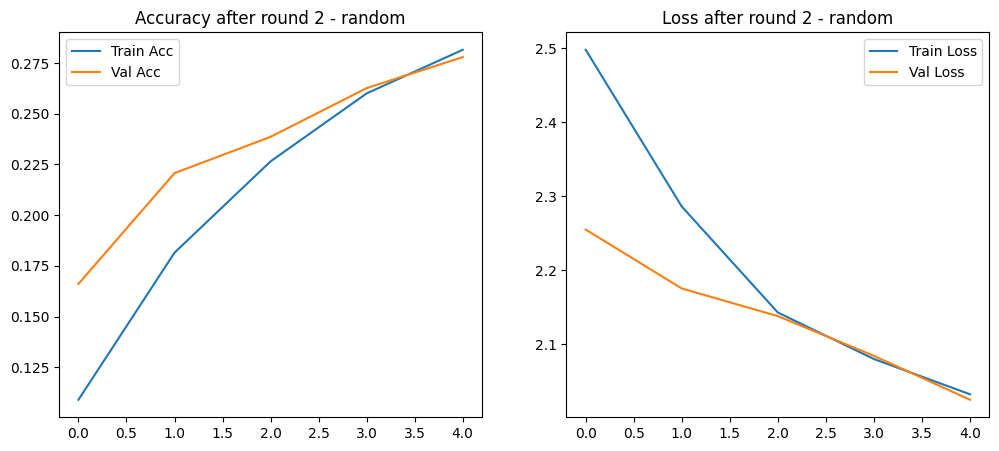


🌀 Round 3 - Strategy: random
Epoch 1: Train Acc=0.150, Val Acc=0.242
Epoch 2: Train Acc=0.235, Val Acc=0.270
Epoch 3: Train Acc=0.271, Val Acc=0.281
Epoch 4: Train Acc=0.279, Val Acc=0.291
Epoch 5: Train Acc=0.303, Val Acc=0.291


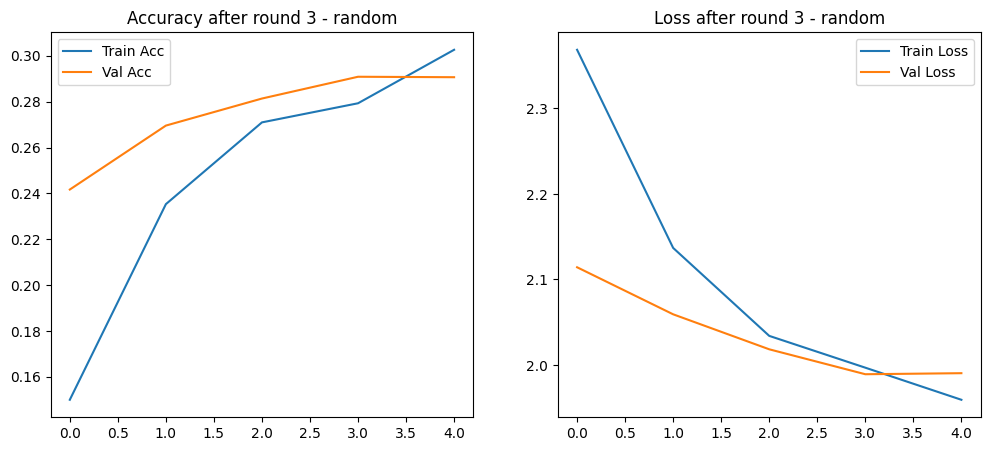


🌀 Round 4 - Strategy: random
Epoch 1: Train Acc=0.163, Val Acc=0.211
Epoch 2: Train Acc=0.253, Val Acc=0.245
Epoch 3: Train Acc=0.278, Val Acc=0.284
Epoch 4: Train Acc=0.299, Val Acc=0.295
Epoch 5: Train Acc=0.314, Val Acc=0.306


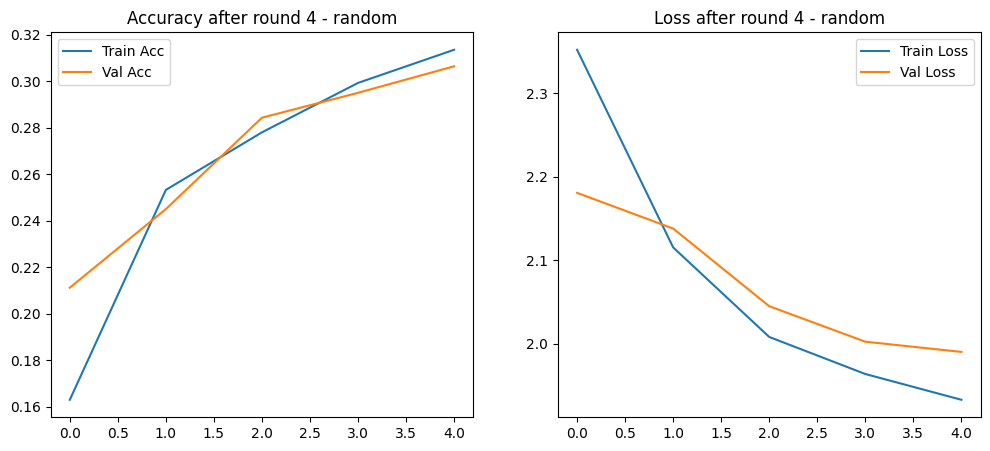


🌀 Round 5 - Strategy: random
Epoch 1: Train Acc=0.163, Val Acc=0.247
Epoch 2: Train Acc=0.263, Val Acc=0.275
Epoch 3: Train Acc=0.285, Val Acc=0.293
Epoch 4: Train Acc=0.304, Val Acc=0.310
Epoch 5: Train Acc=0.314, Val Acc=0.322


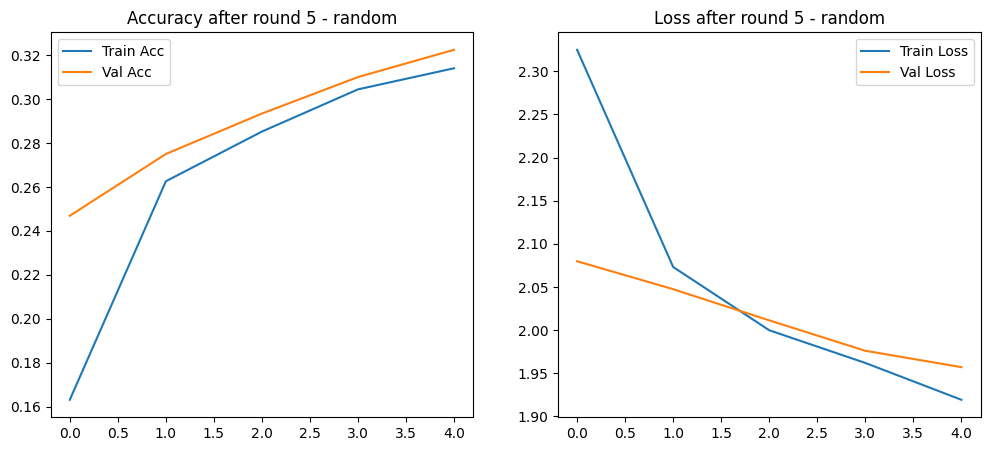


🌀 Round 6 - Strategy: random
Epoch 1: Train Acc=0.182, Val Acc=0.251
Epoch 2: Train Acc=0.272, Val Acc=0.298
Epoch 3: Train Acc=0.294, Val Acc=0.316
Epoch 4: Train Acc=0.317, Val Acc=0.317
Epoch 5: Train Acc=0.331, Val Acc=0.331


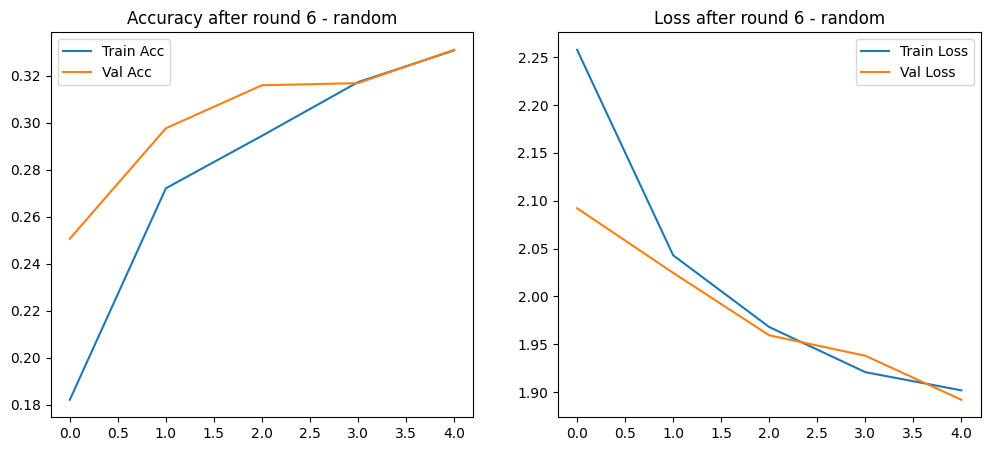


🌀 Round 7 - Strategy: random
Epoch 1: Train Acc=0.186, Val Acc=0.259
Epoch 2: Train Acc=0.285, Val Acc=0.302
Epoch 3: Train Acc=0.301, Val Acc=0.318
Epoch 4: Train Acc=0.326, Val Acc=0.325
Epoch 5: Train Acc=0.321, Val Acc=0.328


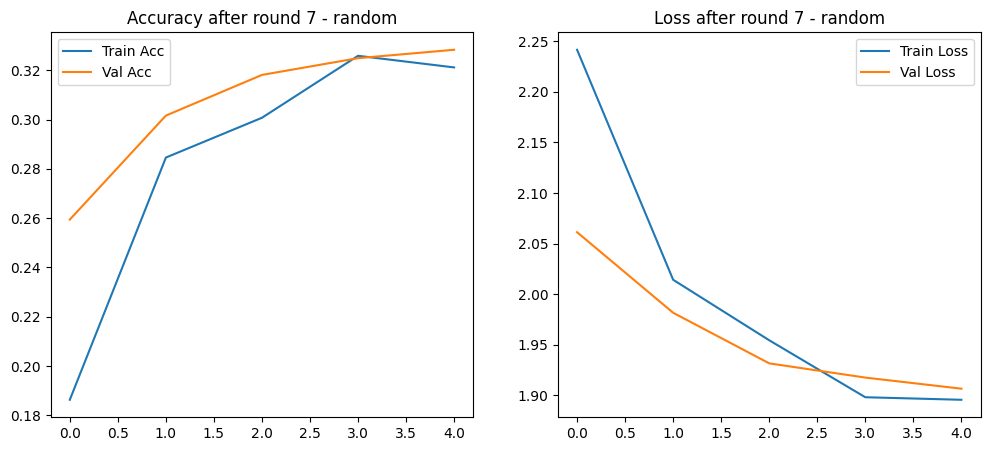


🌀 Round 8 - Strategy: random
Epoch 1: Train Acc=0.194, Val Acc=0.256
Epoch 2: Train Acc=0.285, Val Acc=0.296
Epoch 3: Train Acc=0.315, Val Acc=0.309
Epoch 4: Train Acc=0.330, Val Acc=0.315
Epoch 5: Train Acc=0.332, Val Acc=0.325


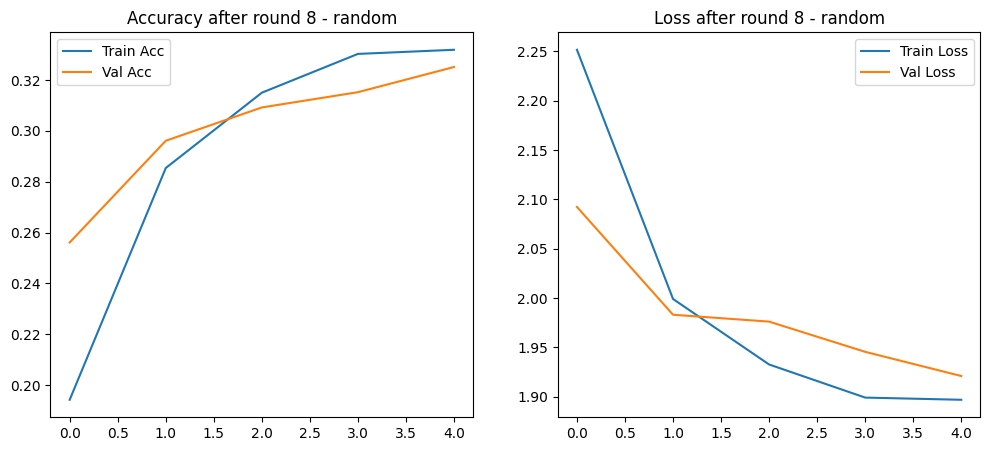


🌀 Round 9 - Strategy: random
Epoch 1: Train Acc=0.206, Val Acc=0.285
Epoch 2: Train Acc=0.297, Val Acc=0.296
Epoch 3: Train Acc=0.314, Val Acc=0.332
Epoch 4: Train Acc=0.324, Val Acc=0.340
Epoch 5: Train Acc=0.330, Val Acc=0.319


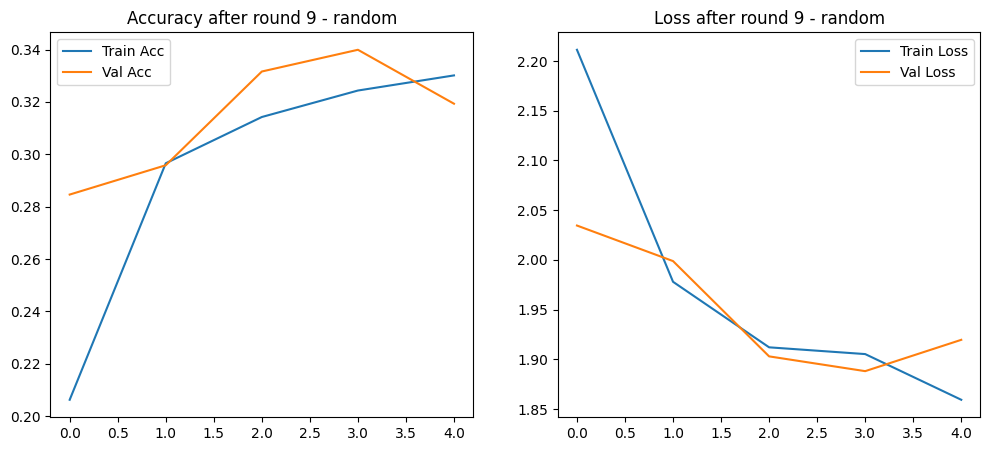


🌀 Round 10 - Strategy: random
Epoch 1: Train Acc=0.221, Val Acc=0.278
Epoch 2: Train Acc=0.291, Val Acc=0.313
Epoch 3: Train Acc=0.326, Val Acc=0.316
Epoch 4: Train Acc=0.325, Val Acc=0.326
Epoch 5: Train Acc=0.334, Val Acc=0.342


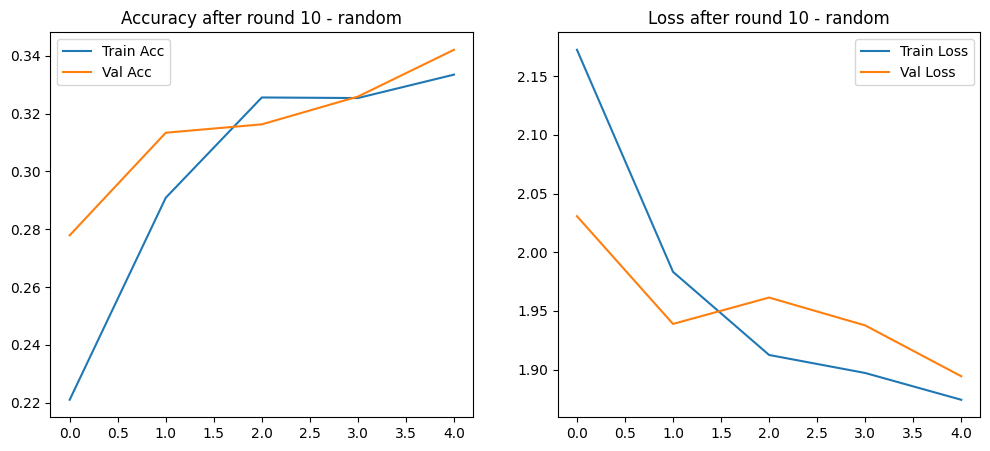

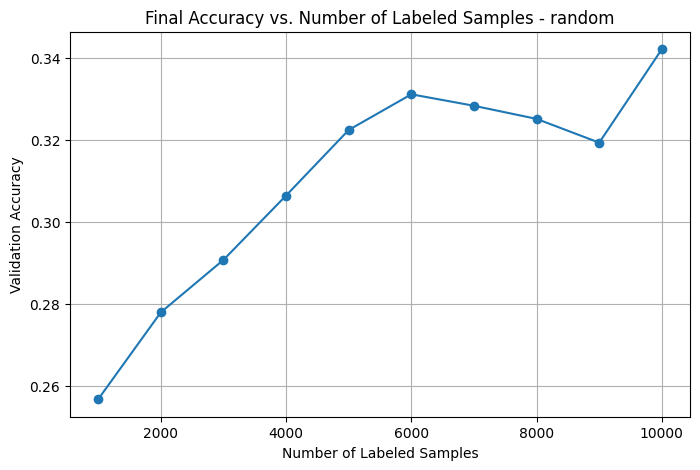

In [ ]:
# Options: 'random', 'entropy', 'margin', 'least_confident', 'density', 'diversity'
strategy = 'random'
active_learning_loop(strategy=strategy)



🌀 Round 1 - Strategy: entropy
Epoch 1: Train Acc=0.091, Val Acc=0.160
Epoch 2: Train Acc=0.146, Val Acc=0.205
Epoch 3: Train Acc=0.166, Val Acc=0.231
Epoch 4: Train Acc=0.208, Val Acc=0.249
Epoch 5: Train Acc=0.233, Val Acc=0.256


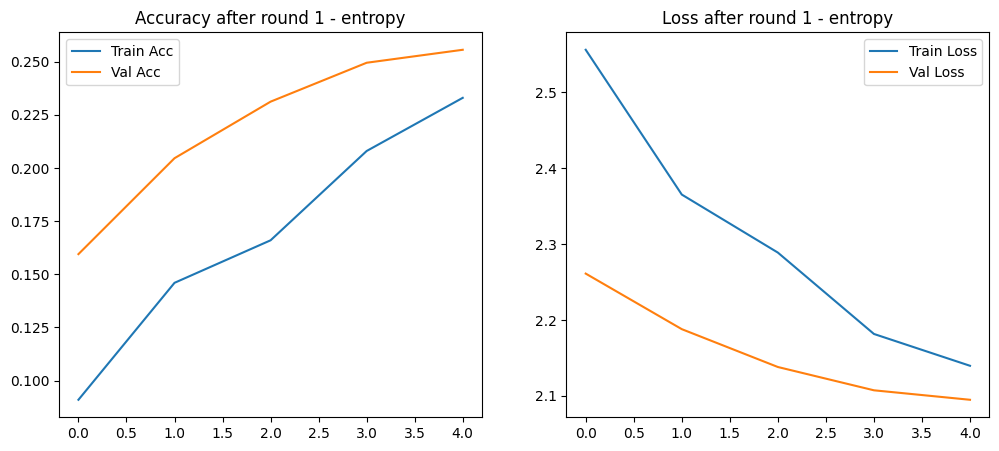


🌀 Round 2 - Strategy: entropy
Epoch 1: Train Acc=0.114, Val Acc=0.164
Epoch 2: Train Acc=0.170, Val Acc=0.225
Epoch 3: Train Acc=0.224, Val Acc=0.253
Epoch 4: Train Acc=0.239, Val Acc=0.273
Epoch 5: Train Acc=0.268, Val Acc=0.278


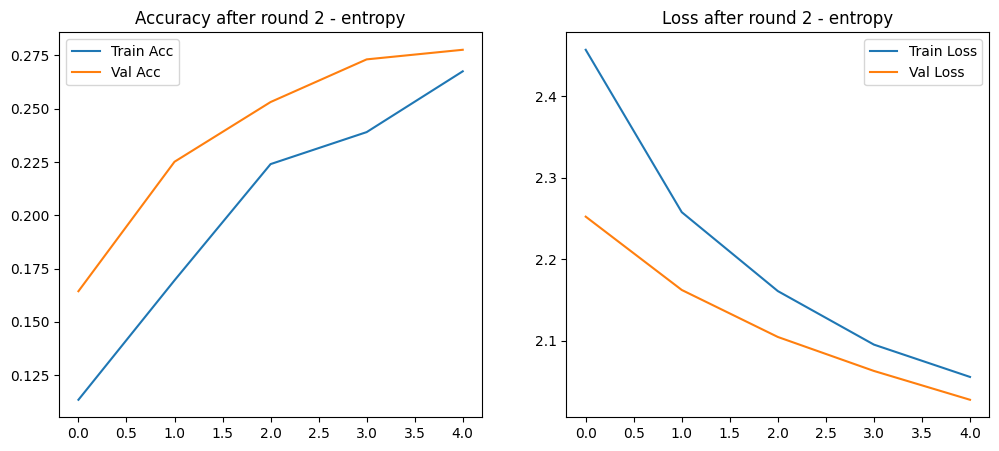


🌀 Round 3 - Strategy: entropy
Epoch 1: Train Acc=0.134, Val Acc=0.201
Epoch 2: Train Acc=0.198, Val Acc=0.250
Epoch 3: Train Acc=0.233, Val Acc=0.273
Epoch 4: Train Acc=0.258, Val Acc=0.294
Epoch 5: Train Acc=0.266, Val Acc=0.302


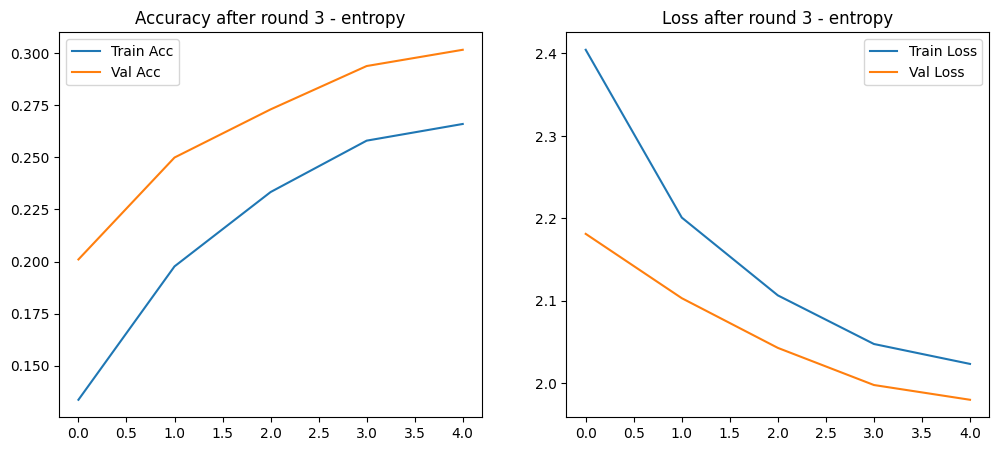


🌀 Round 4 - Strategy: entropy
Epoch 1: Train Acc=0.135, Val Acc=0.218
Epoch 2: Train Acc=0.211, Val Acc=0.258
Epoch 3: Train Acc=0.242, Val Acc=0.283
Epoch 4: Train Acc=0.275, Val Acc=0.297
Epoch 5: Train Acc=0.294, Val Acc=0.302


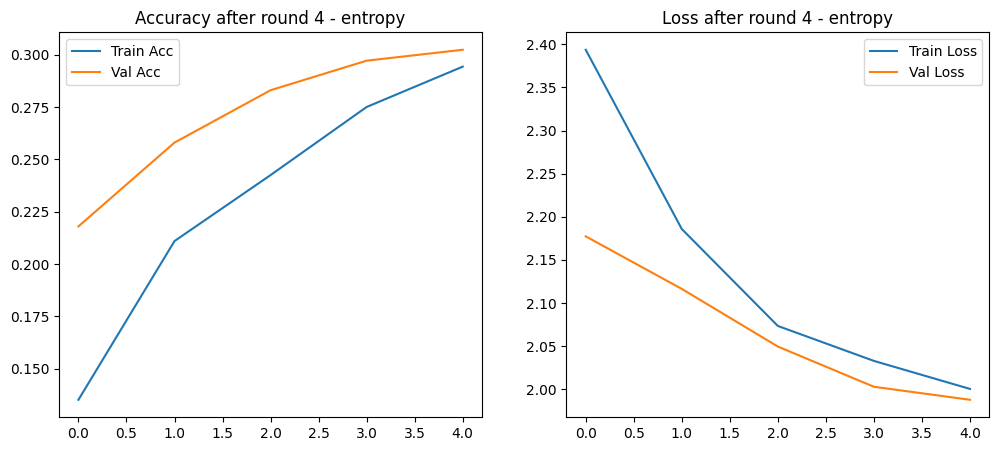


🌀 Round 5 - Strategy: entropy
Epoch 1: Train Acc=0.164, Val Acc=0.240
Epoch 2: Train Acc=0.241, Val Acc=0.274
Epoch 3: Train Acc=0.264, Val Acc=0.294
Epoch 4: Train Acc=0.273, Val Acc=0.294
Epoch 5: Train Acc=0.288, Val Acc=0.318


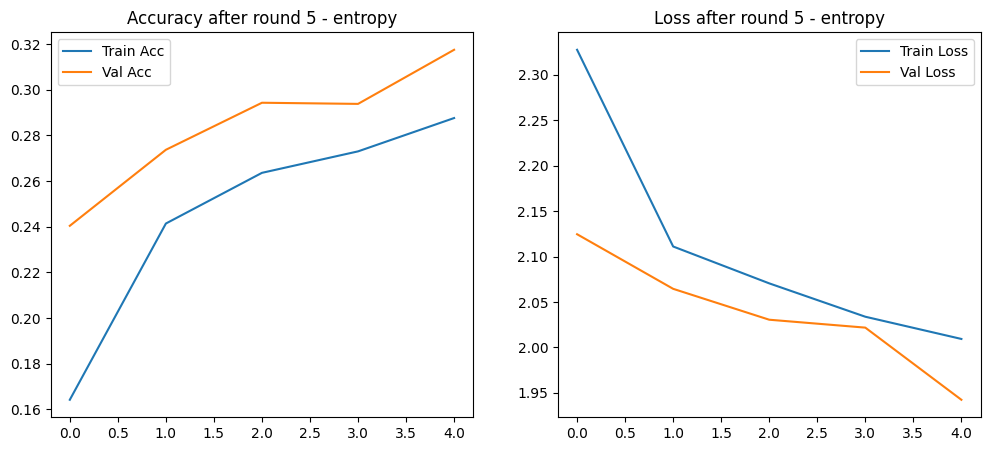


🌀 Round 6 - Strategy: entropy
Epoch 1: Train Acc=0.164, Val Acc=0.228
Epoch 2: Train Acc=0.238, Val Acc=0.268
Epoch 3: Train Acc=0.265, Val Acc=0.300
Epoch 4: Train Acc=0.285, Val Acc=0.323
Epoch 5: Train Acc=0.293, Val Acc=0.331


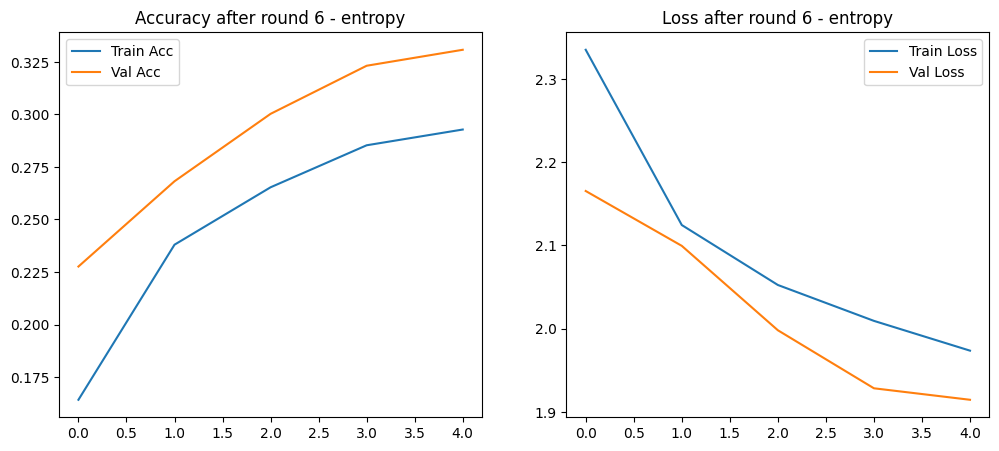


🌀 Round 7 - Strategy: entropy
Epoch 1: Train Acc=0.163, Val Acc=0.260
Epoch 2: Train Acc=0.252, Val Acc=0.304
Epoch 3: Train Acc=0.269, Val Acc=0.315
Epoch 4: Train Acc=0.288, Val Acc=0.329
Epoch 5: Train Acc=0.295, Val Acc=0.327


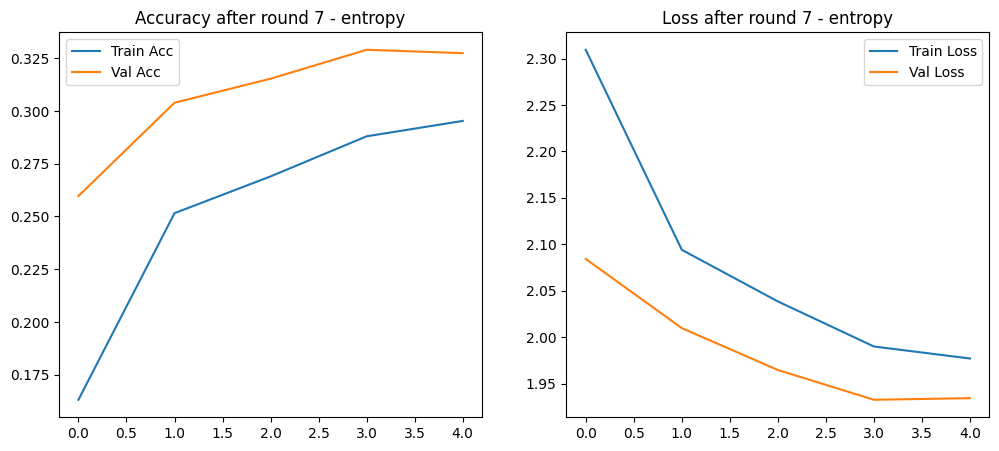


🌀 Round 8 - Strategy: entropy
Epoch 1: Train Acc=0.173, Val Acc=0.271
Epoch 2: Train Acc=0.249, Val Acc=0.301
Epoch 3: Train Acc=0.280, Val Acc=0.312
Epoch 4: Train Acc=0.285, Val Acc=0.329
Epoch 5: Train Acc=0.289, Val Acc=0.325


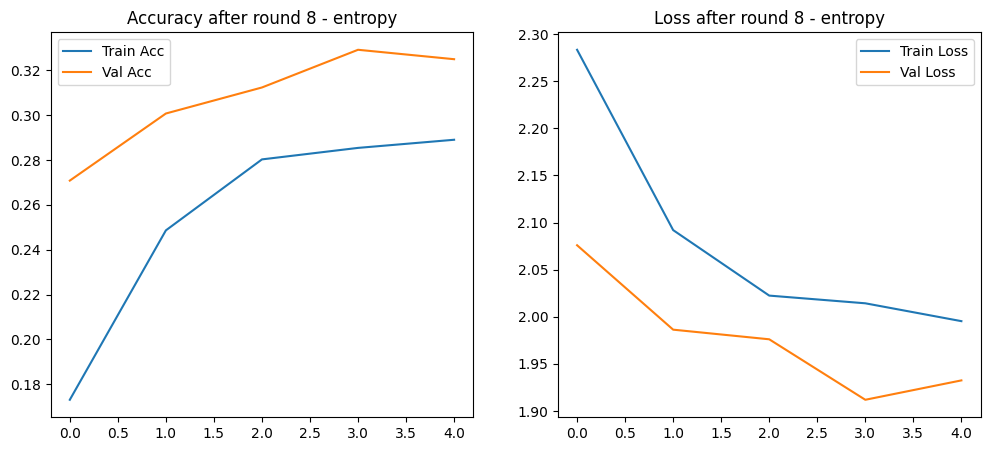


🌀 Round 9 - Strategy: entropy
Epoch 1: Train Acc=0.176, Val Acc=0.264
Epoch 2: Train Acc=0.257, Val Acc=0.300
Epoch 3: Train Acc=0.275, Val Acc=0.324
Epoch 4: Train Acc=0.292, Val Acc=0.327
Epoch 5: Train Acc=0.288, Val Acc=0.344


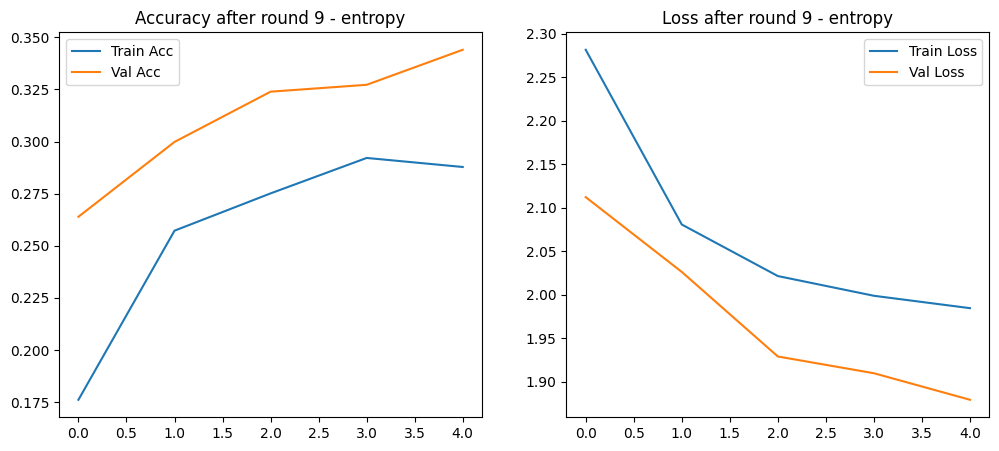


🌀 Round 10 - Strategy: entropy
Epoch 1: Train Acc=0.173, Val Acc=0.272
Epoch 2: Train Acc=0.254, Val Acc=0.312
Epoch 3: Train Acc=0.276, Val Acc=0.318
Epoch 4: Train Acc=0.289, Val Acc=0.338
Epoch 5: Train Acc=0.292, Val Acc=0.343


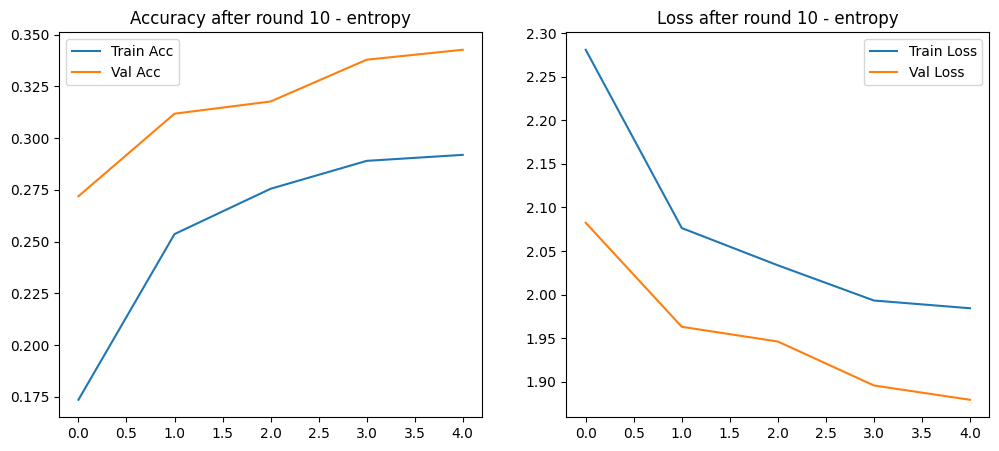

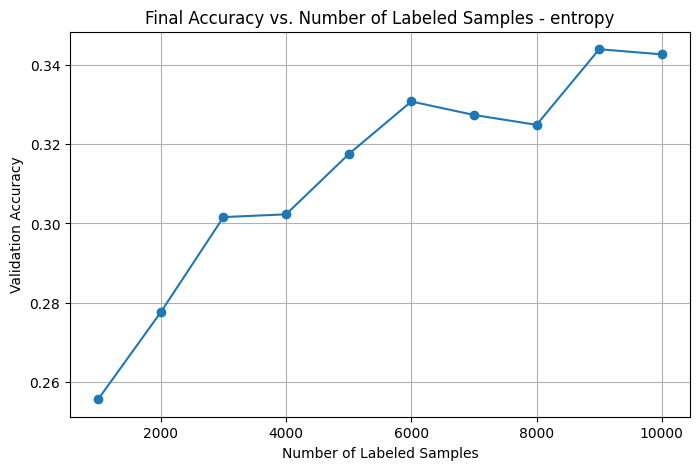

In [ ]:
active_learning_loop(strategy='entropy')


🌀 Round 1 - Strategy: margin
Epoch 1: Train Acc=0.106, Val Acc=0.148
Epoch 2: Train Acc=0.173, Val Acc=0.196
Epoch 3: Train Acc=0.159, Val Acc=0.215
Epoch 4: Train Acc=0.212, Val Acc=0.237
Epoch 5: Train Acc=0.218, Val Acc=0.241


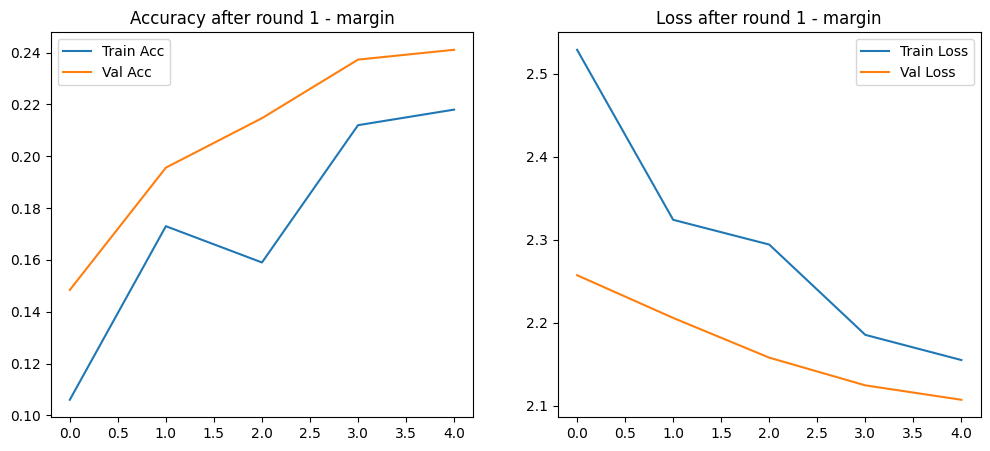


🌀 Round 2 - Strategy: margin
Epoch 1: Train Acc=0.164, Val Acc=0.203
Epoch 2: Train Acc=0.233, Val Acc=0.225
Epoch 3: Train Acc=0.287, Val Acc=0.235
Epoch 4: Train Acc=0.320, Val Acc=0.265
Epoch 5: Train Acc=0.313, Val Acc=0.270


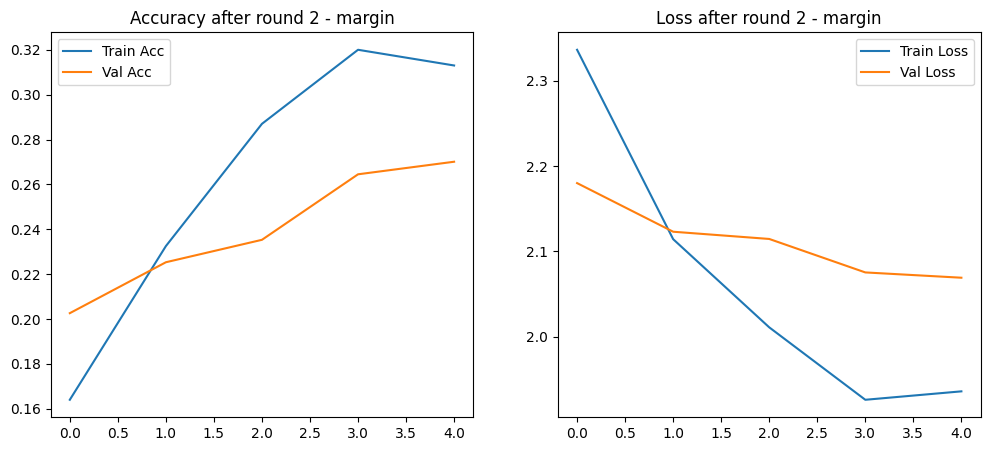


🌀 Round 3 - Strategy: margin
Epoch 1: Train Acc=0.177, Val Acc=0.230
Epoch 2: Train Acc=0.300, Val Acc=0.249
Epoch 3: Train Acc=0.353, Val Acc=0.264
Epoch 4: Train Acc=0.369, Val Acc=0.273
Epoch 5: Train Acc=0.382, Val Acc=0.295


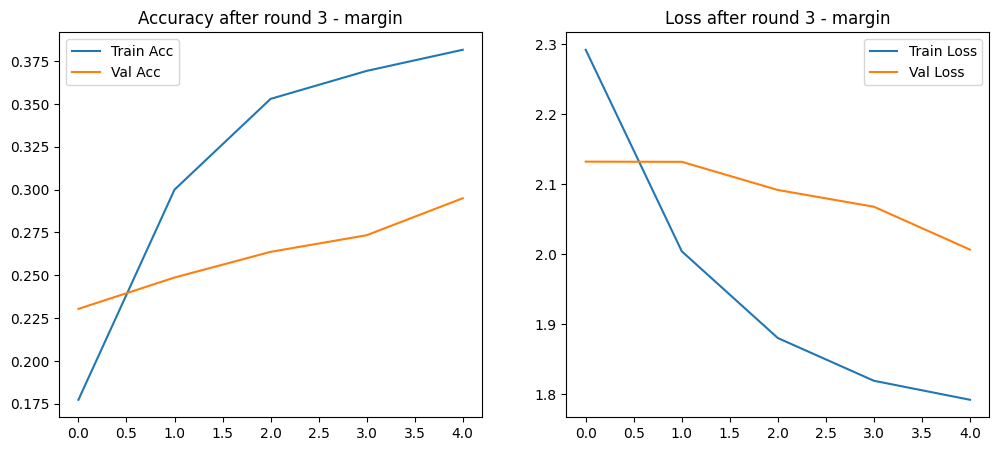


🌀 Round 4 - Strategy: margin
Epoch 1: Train Acc=0.238, Val Acc=0.239
Epoch 2: Train Acc=0.370, Val Acc=0.251
Epoch 3: Train Acc=0.406, Val Acc=0.276
Epoch 4: Train Acc=0.408, Val Acc=0.279
Epoch 5: Train Acc=0.427, Val Acc=0.286


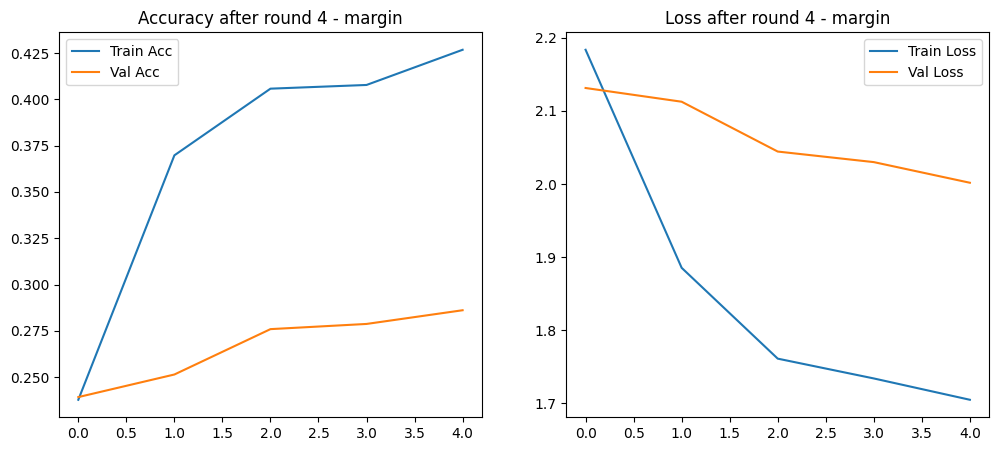


🌀 Round 5 - Strategy: margin
Epoch 1: Train Acc=0.266, Val Acc=0.245
Epoch 2: Train Acc=0.395, Val Acc=0.272
Epoch 3: Train Acc=0.423, Val Acc=0.278
Epoch 4: Train Acc=0.444, Val Acc=0.298
Epoch 5: Train Acc=0.431, Val Acc=0.297


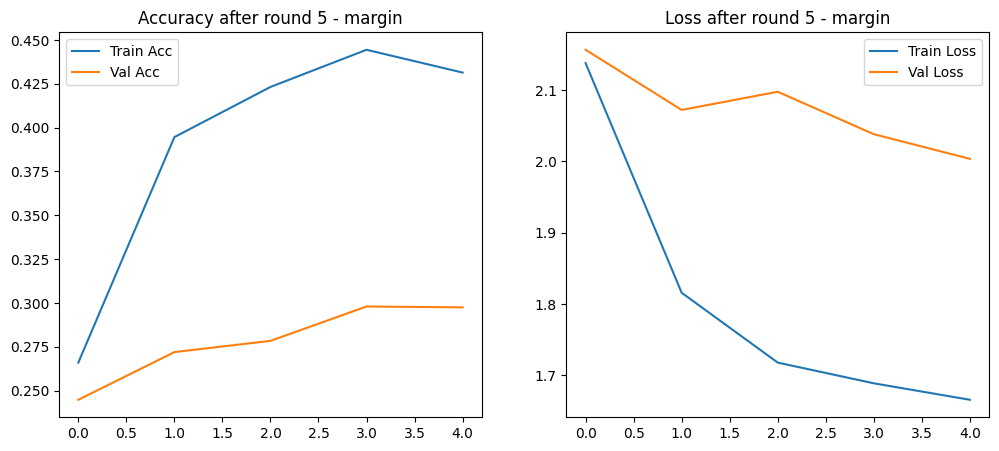


🌀 Round 6 - Strategy: margin
Epoch 1: Train Acc=0.298, Val Acc=0.256
Epoch 2: Train Acc=0.425, Val Acc=0.290
Epoch 3: Train Acc=0.459, Val Acc=0.294
Epoch 4: Train Acc=0.467, Val Acc=0.303
Epoch 5: Train Acc=0.472, Val Acc=0.311


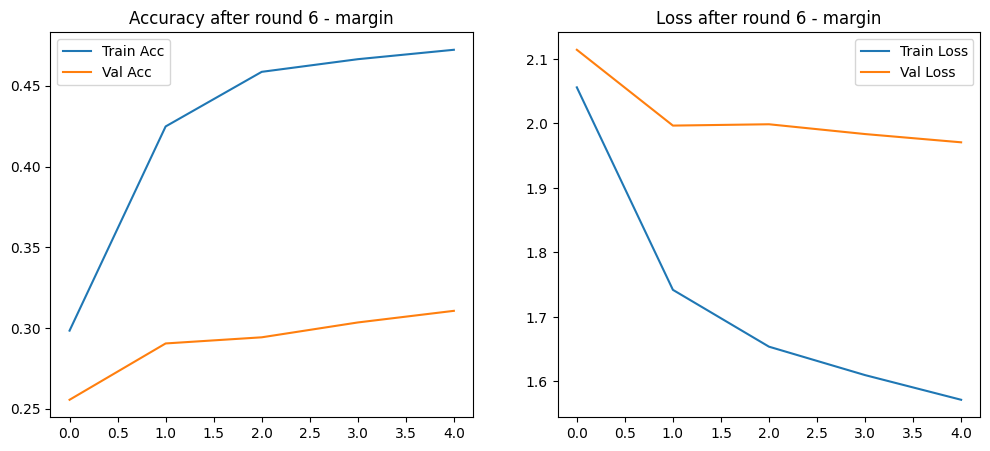


🌀 Round 7 - Strategy: margin
Epoch 1: Train Acc=0.320, Val Acc=0.255
Epoch 2: Train Acc=0.444, Val Acc=0.274
Epoch 3: Train Acc=0.476, Val Acc=0.291
Epoch 4: Train Acc=0.487, Val Acc=0.306
Epoch 5: Train Acc=0.498, Val Acc=0.320


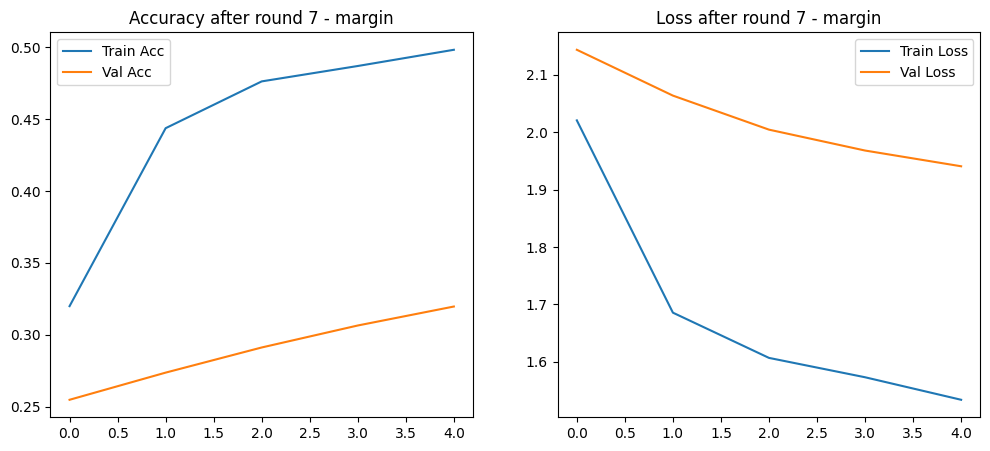


🌀 Round 8 - Strategy: margin
Epoch 1: Train Acc=0.335, Val Acc=0.259
Epoch 2: Train Acc=0.459, Val Acc=0.288
Epoch 3: Train Acc=0.487, Val Acc=0.311
Epoch 4: Train Acc=0.505, Val Acc=0.315
Epoch 5: Train Acc=0.509, Val Acc=0.313


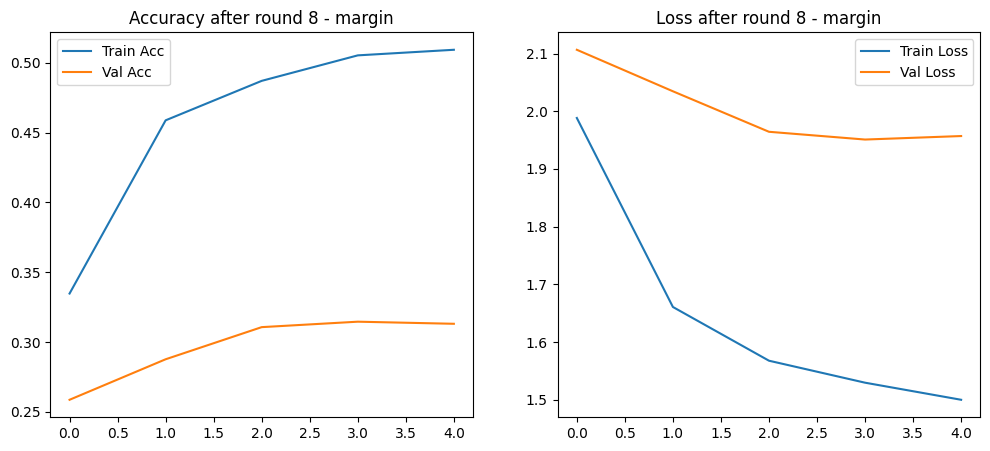


🌀 Round 9 - Strategy: margin
Epoch 1: Train Acc=0.369, Val Acc=0.272
Epoch 2: Train Acc=0.483, Val Acc=0.290
Epoch 3: Train Acc=0.503, Val Acc=0.303
Epoch 4: Train Acc=0.511, Val Acc=0.312
Epoch 5: Train Acc=0.522, Val Acc=0.313


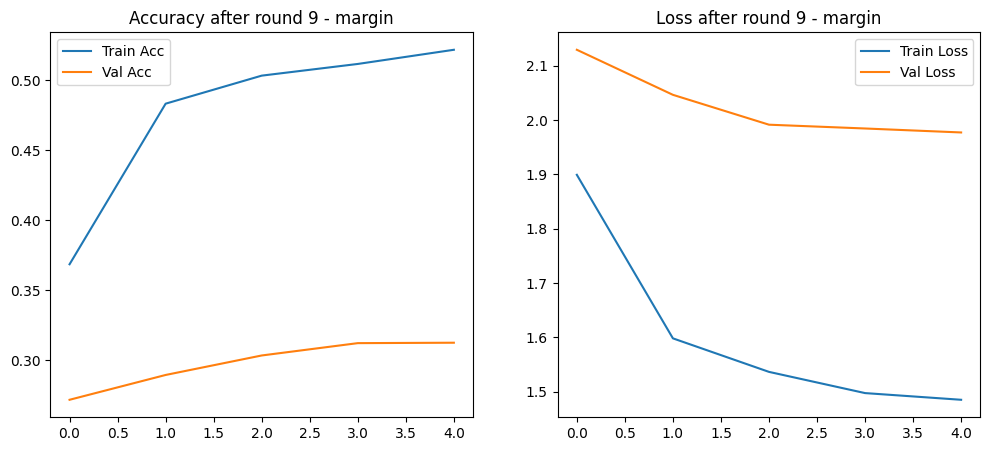


🌀 Round 10 - Strategy: margin
Epoch 1: Train Acc=0.394, Val Acc=0.264
Epoch 2: Train Acc=0.489, Val Acc=0.296
Epoch 3: Train Acc=0.509, Val Acc=0.289
Epoch 4: Train Acc=0.519, Val Acc=0.315
Epoch 5: Train Acc=0.526, Val Acc=0.326


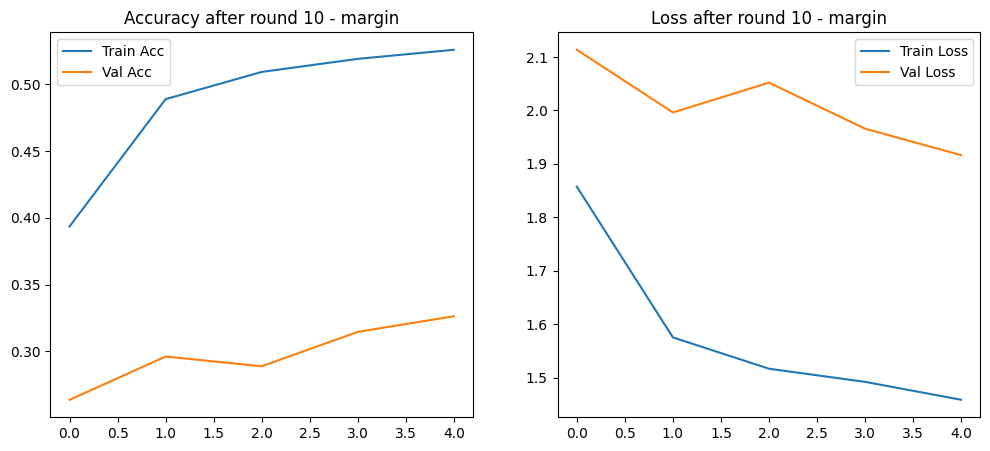

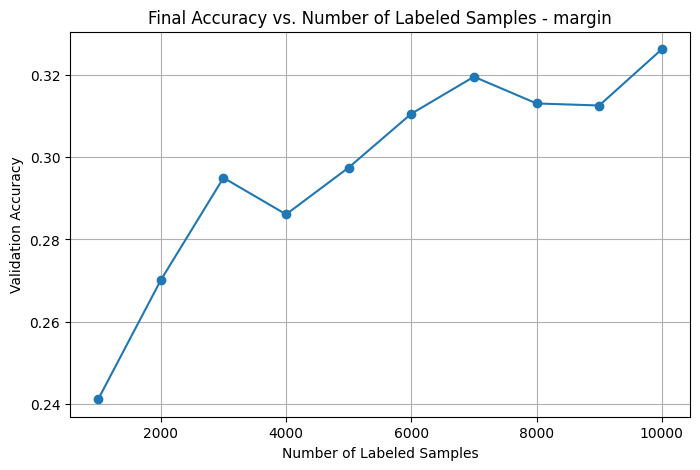

In [ ]:
active_learning_loop(strategy='margin')


🌀 Round 1 - Strategy: least_confident
Epoch 1: Train Acc=0.113, Val Acc=0.145
Epoch 2: Train Acc=0.156, Val Acc=0.196
Epoch 3: Train Acc=0.176, Val Acc=0.219
Epoch 4: Train Acc=0.202, Val Acc=0.237
Epoch 5: Train Acc=0.229, Val Acc=0.255


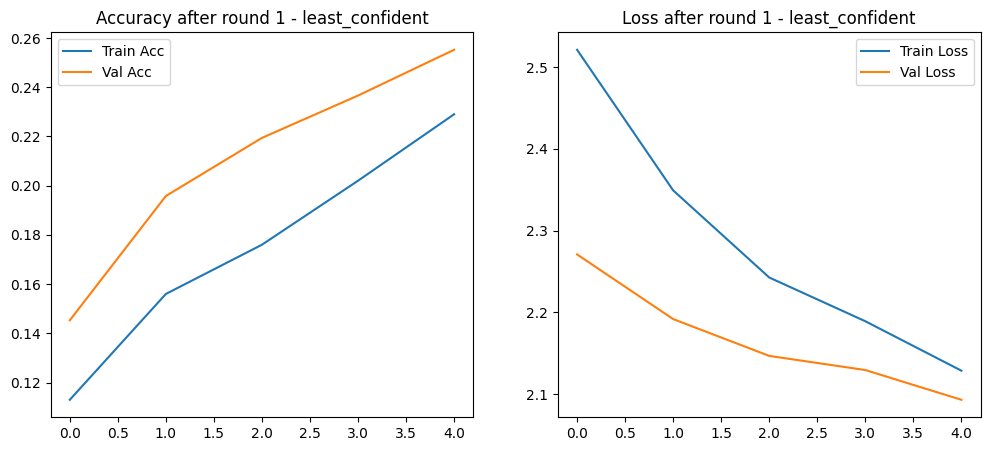


🌀 Round 2 - Strategy: least_confident
Epoch 1: Train Acc=0.131, Val Acc=0.185
Epoch 2: Train Acc=0.181, Val Acc=0.208
Epoch 3: Train Acc=0.210, Val Acc=0.236
Epoch 4: Train Acc=0.242, Val Acc=0.261
Epoch 5: Train Acc=0.260, Val Acc=0.278


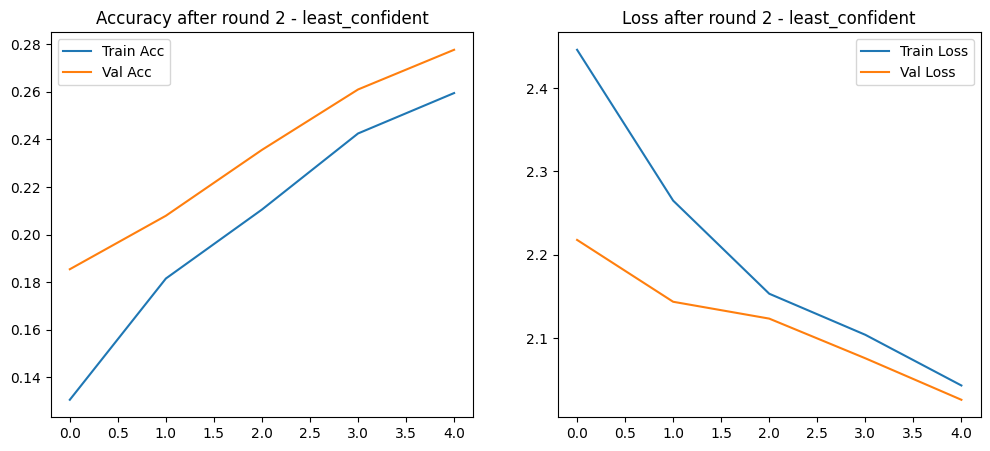


🌀 Round 3 - Strategy: least_confident
Epoch 1: Train Acc=0.140, Val Acc=0.215
Epoch 2: Train Acc=0.204, Val Acc=0.241
Epoch 3: Train Acc=0.238, Val Acc=0.259
Epoch 4: Train Acc=0.263, Val Acc=0.288
Epoch 5: Train Acc=0.278, Val Acc=0.302


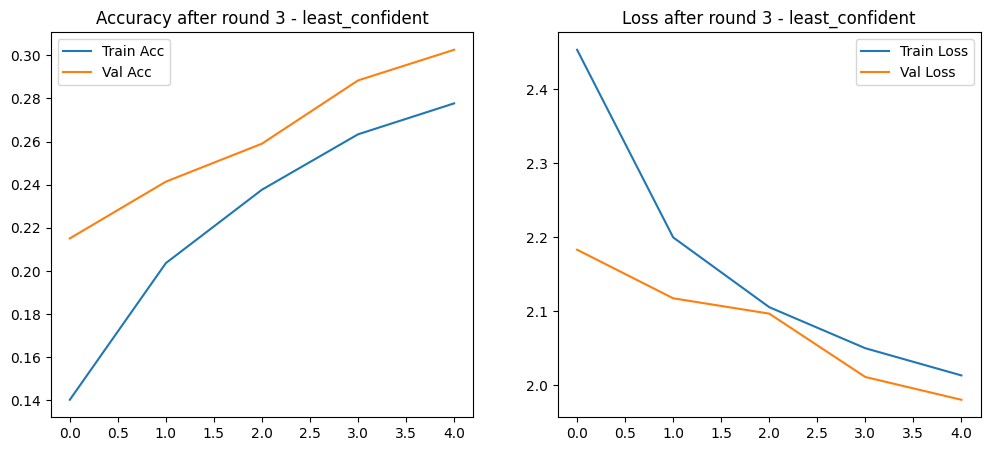


🌀 Round 4 - Strategy: least_confident
Epoch 1: Train Acc=0.143, Val Acc=0.229
Epoch 2: Train Acc=0.218, Val Acc=0.266
Epoch 3: Train Acc=0.240, Val Acc=0.287
Epoch 4: Train Acc=0.265, Val Acc=0.288
Epoch 5: Train Acc=0.282, Val Acc=0.299


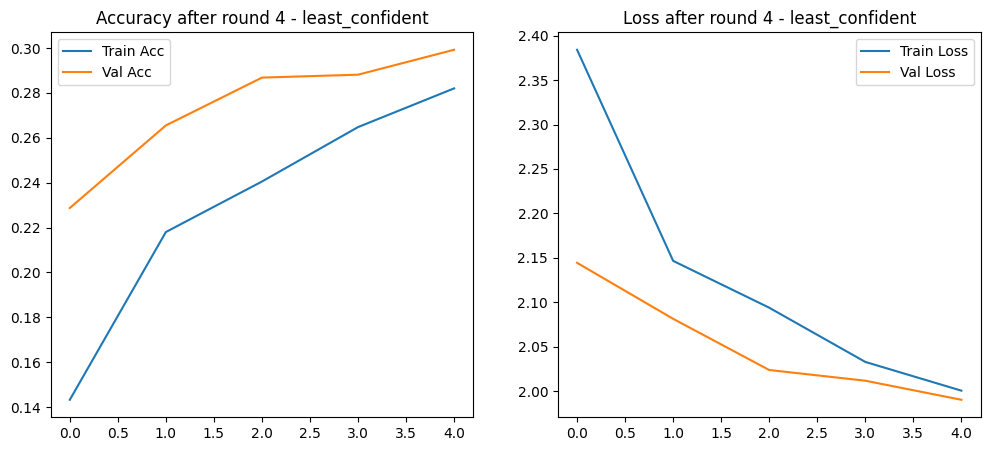


🌀 Round 5 - Strategy: least_confident
Epoch 1: Train Acc=0.152, Val Acc=0.250
Epoch 2: Train Acc=0.220, Val Acc=0.291
Epoch 3: Train Acc=0.248, Val Acc=0.287
Epoch 4: Train Acc=0.264, Val Acc=0.310
Epoch 5: Train Acc=0.279, Val Acc=0.316


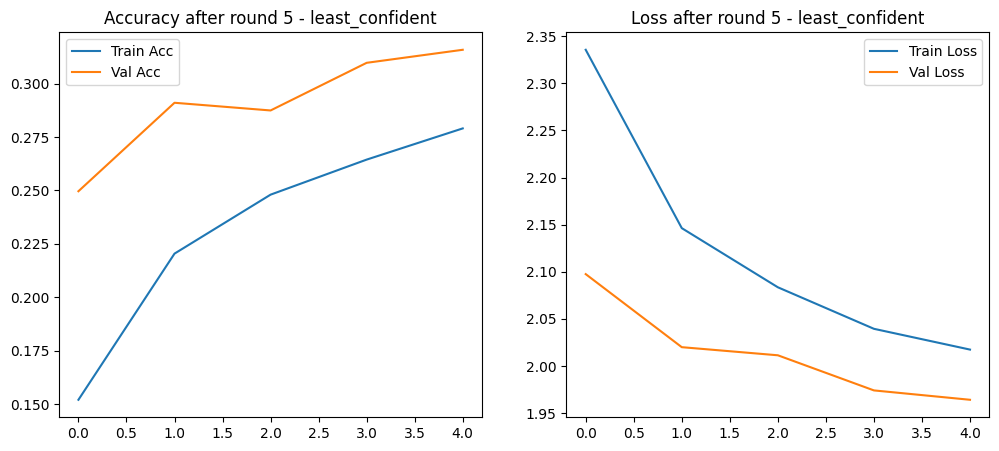


🌀 Round 6 - Strategy: least_confident
Epoch 1: Train Acc=0.150, Val Acc=0.222
Epoch 2: Train Acc=0.238, Val Acc=0.268
Epoch 3: Train Acc=0.261, Val Acc=0.294
Epoch 4: Train Acc=0.288, Val Acc=0.321
Epoch 5: Train Acc=0.286, Val Acc=0.315


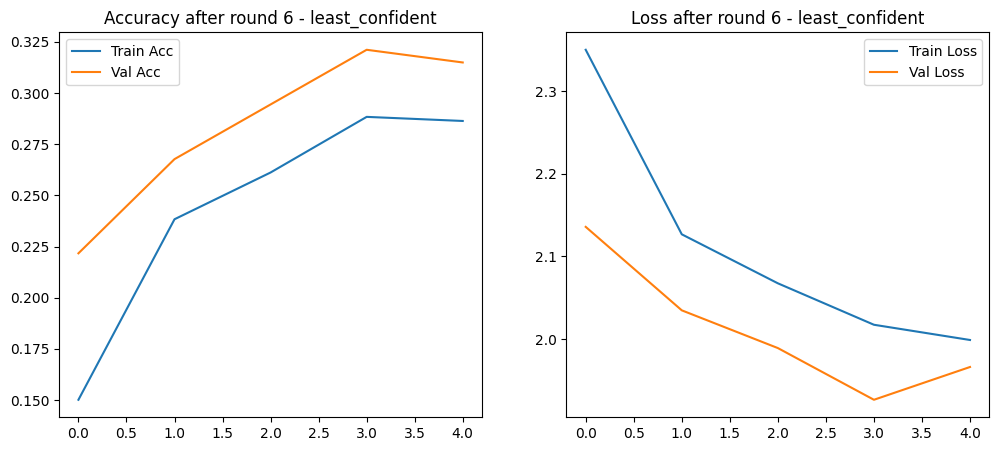


🌀 Round 7 - Strategy: least_confident
Epoch 1: Train Acc=0.154, Val Acc=0.250
Epoch 2: Train Acc=0.235, Val Acc=0.297
Epoch 3: Train Acc=0.262, Val Acc=0.303
Epoch 4: Train Acc=0.275, Val Acc=0.313
Epoch 5: Train Acc=0.290, Val Acc=0.322


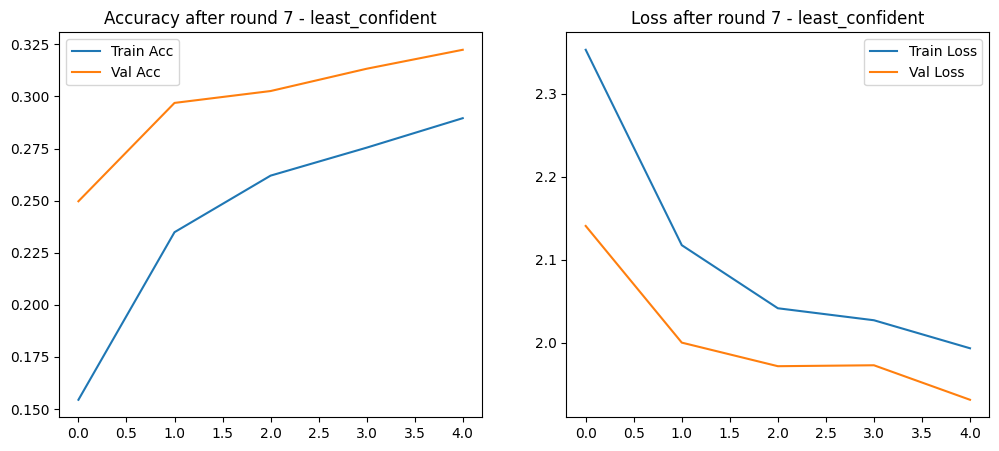


🌀 Round 8 - Strategy: least_confident
Epoch 1: Train Acc=0.165, Val Acc=0.261
Epoch 2: Train Acc=0.238, Val Acc=0.295
Epoch 3: Train Acc=0.264, Val Acc=0.324
Epoch 4: Train Acc=0.274, Val Acc=0.333
Epoch 5: Train Acc=0.286, Val Acc=0.329


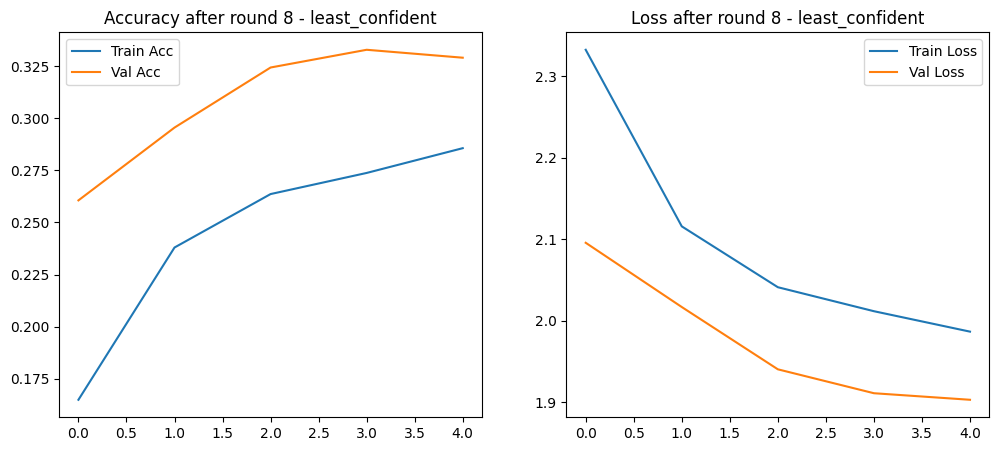


🌀 Round 9 - Strategy: least_confident
Epoch 1: Train Acc=0.171, Val Acc=0.258
Epoch 2: Train Acc=0.235, Val Acc=0.297
Epoch 3: Train Acc=0.275, Val Acc=0.332
Epoch 4: Train Acc=0.285, Val Acc=0.319
Epoch 5: Train Acc=0.289, Val Acc=0.337


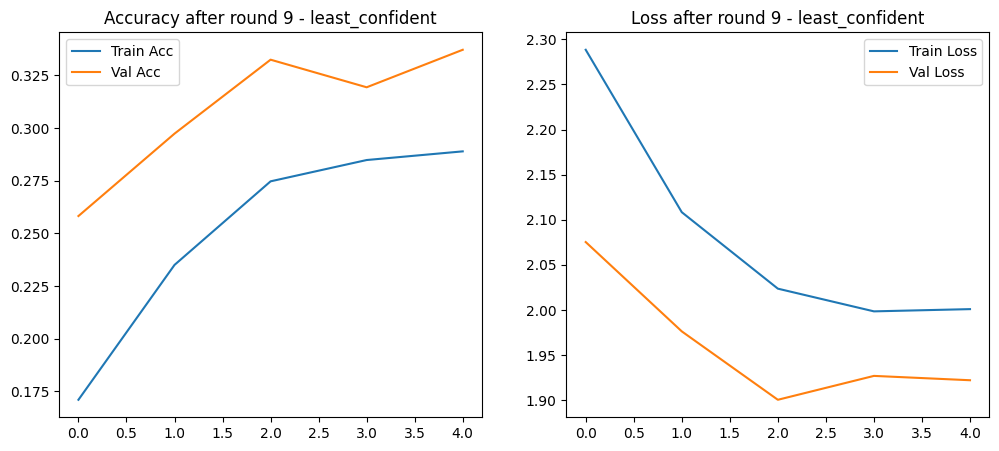


🌀 Round 10 - Strategy: least_confident
Epoch 1: Train Acc=0.170, Val Acc=0.262
Epoch 2: Train Acc=0.247, Val Acc=0.313
Epoch 3: Train Acc=0.263, Val Acc=0.308
Epoch 4: Train Acc=0.279, Val Acc=0.329
Epoch 5: Train Acc=0.292, Val Acc=0.319


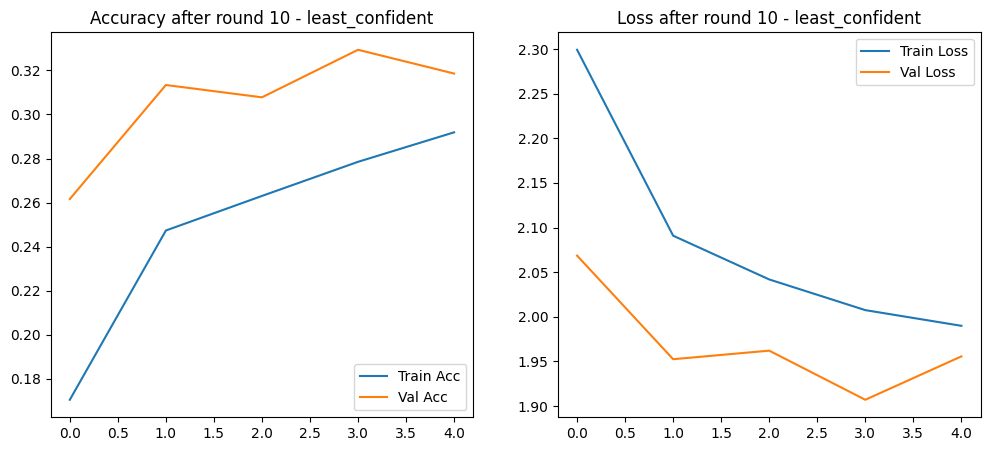

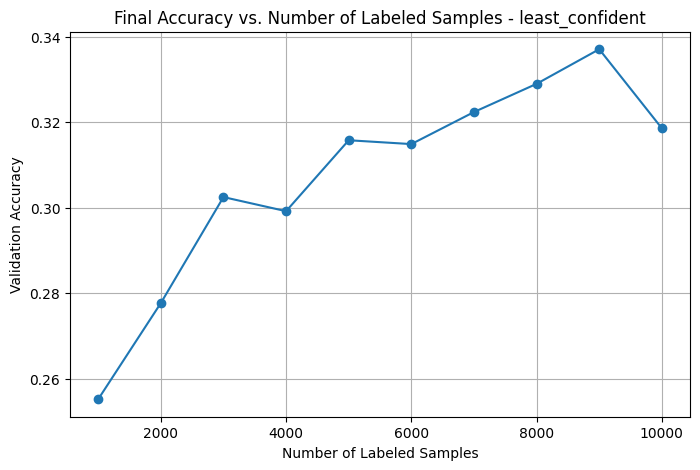

In [ ]:
active_learning_loop(strategy='least_confident')


🌀 Round 1 - Strategy: density
Epoch 1: Train Acc=0.120, Val Acc=0.137
Epoch 2: Train Acc=0.148, Val Acc=0.177
Epoch 3: Train Acc=0.206, Val Acc=0.208
Epoch 4: Train Acc=0.213, Val Acc=0.230
Epoch 5: Train Acc=0.229, Val Acc=0.239


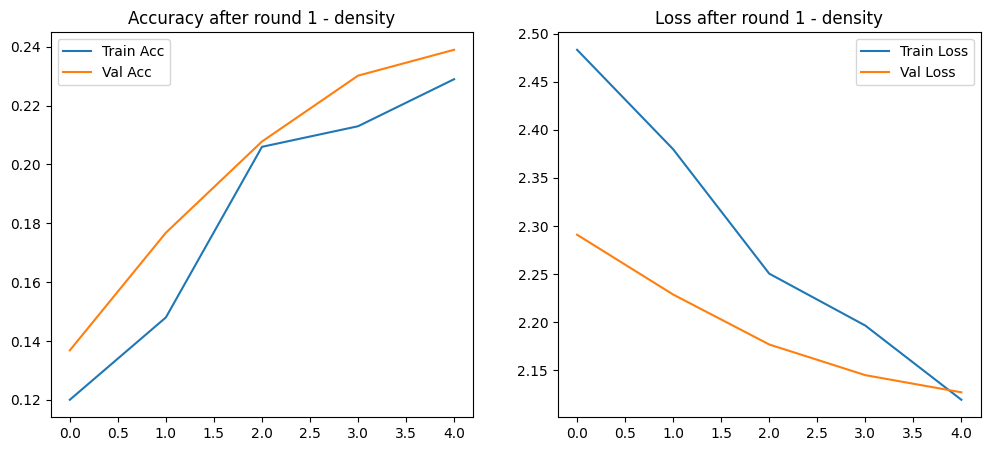

In [ ]:
active_learning_loop(strategy='density')

In [ ]:
active_learning_loop(strategy='diversity')

NameError: name 'active_learning_loop' is not defined